**INSERT CREDITS**

# Air Quality Analytics Collaborative Framework (AQACF) API Demonstration

This notebook highlits some of the analytics and visualization capabilities of AQACF with three usecases:
1. Los Angeles ports backlog Fall 2021
2. Fireworks during 4th of July 2022 in Los Angeles county
3. 2020 California Wildfires

## Libraries 
The following libraries are needed to support accessing AQACF API

In [2]:
# Libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
#from mpl_toolkits.basemap import Basemap
from datetime import datetime
from shapely.geometry import box
import time 
import xarray as xr
import numpy as np
from typing import List

import ideas_modules.plotting as plotting
import ideas_modules.ideas_processing as ideas_processing

ImportError: dlopen(/opt/anaconda3/envs/aqacf_notebook/lib/python3.10/site-packages/pyproj/_network.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libtiff.5.dylib
  Referenced from: <A434F4C2-A5F2-33DB-95DB-37691DE48C0E> /opt/anaconda3/envs/aqacf_notebook/lib/libproj.22.2.1.dylib
  Reason: tried: '/opt/anaconda3/envs/aqacf_notebook/lib/libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/lib/python3.10/site-packages/pyproj/../../../libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/lib/python3.10/site-packages/pyproj/../../../libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/bin/../lib/libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/bin/../lib/libtiff.5.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/lib/libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/lib/python3.10/site-packages/pyproj/../../../libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/lib/python3.10/site-packages/pyproj/../../../libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/bin/../lib/libtiff.5.dylib' (no such file), '/opt/anaconda3/envs/aqacf_notebook/bin/../lib/libtiff.5.dylib' (no such file), '/usr/local/lib/libtiff.5.dylib' (no such file), '/usr/lib/libtiff.5.dylib' (no such file, not in dyld cache)

## Functions (extract these into a file later)

In [2]:
# Default values
DEFAULT_BASEMAP_RANGE = {
    'llcrnrlon': -180,
    'llcrnrlat': -90,
    'urcrnrlon': 180,
    'urcrnrlat': 90
}
dt_format = "%Y-%m-%dT%H:%M:%SZ"
units = {
    'pm25': 'µg/m³',
    'O3': 'mol m-2',
    'SO2': 'mmol/m2',
    'NO2': 'umol/m2',
    'CO': 'ppb',
    'CH4': 'ppb'
}
url_in_situ            = 'https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0'
endpoint_in_situ       = 'query_data_doms'
start_index_in_situ    = 0
items_per_page_in_situ = 500

In [3]:
def plot_box(bbox, basemap_range=DEFAULT_BASEMAP_RANGE):
    """
    Display a Green bounding box on an image of the blue marble.
    
    :param bbox: Shapely Polygon that defines the bounding box to display
    """
    min_lon, min_lat, max_lon, max_lat = bbox.bounds
    fig = plt.figure(figsize=(15,10))
        
    m = Basemap(llcrnrlon=basemap_range['llcrnrlon'],llcrnrlat=basemap_range['llcrnrlat'], urcrnrlon=basemap_range['urcrnrlon'], urcrnrlat=basemap_range['urcrnrlat'])
    m.shadedrelief(scale=0.5)
    m.drawcoastlines()
    m.drawmapboundary()
    poly = Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)],
                   facecolor=(0,0,0,0.0),edgecolor='black',linewidth=3, linestyle='--')
    plt.gca().add_patch(poly)
    
    plt.show()
    
def spatial_mean(base_url, dataset, bb, start_time, end_time, proc=[]):
    url = '{}/timeSeriesSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}&lowPassFilter=False&seasonalFilter=False'.\
        format(base_url, dataset, bb['min_lon'], bb['min_lat'], bb['max_lon'], bb['max_lat'],
               start_time.strftime(dt_format), end_time.strftime(dt_format))

    # Display some information about the job
    print(url); print()

    # Query SDAP to compute the time averaged map
    print("Waiting for response from SDAP...")
    start = time.perf_counter()
    ts_json = requests.get(url, verify=False).json()
    print("Time series took {} seconds".format(time.perf_counter() - start))
    return prep_ts(ts_json, proc)

def prep_ts(ts_json, proc):
    shortname = ts_json['meta'][0]['shortName']
    time = np.array([np.datetime64(ts[0]["iso_time"][:10]) for ts in ts_json["data"]])
    vals = np.array([ts[0]["mean"] for ts in ts_json["data"]])
    
    da = xr.DataArray(vals, coords = [time], dims=['time'])
    
    for proc in proc:
        da = proc(da)
        
    da.attrs['shortname'] = shortname
        
    return da

def calc_anoms(data):
    return data - np.nanmean(data)

def comparison_plot(data, x_label, y_label, var='', anoms=False):
    plt.figure(figsize=(15,6))
    
    for da in data:
        if anoms:
            vals = calc_anoms(da.values)
        else:
            vals = da.values
        plt.plot(da.time, vals, linewidth=2, label=da.attrs['shortname'])
    
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel (y_label, fontsize=12)
    plt.xticks(rotation=45)
    plt.title(f'{var}{" Anomalies" if anoms else ""}', fontsize=16)
    plt.legend(prop={'size': 12})
#     dtFmt = mdates.DateFormatter('%b %Y') # define the formatting
#     plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.show()
    
def temporal_variance(base_url, dataset, bb, start_time, end_time):
    params = {
        'ds': dataset,
        'minLon': bb['min_lon'],
        'minLat': bb['min_lat'],
        'maxLon': bb['max_lon'],
        'maxLat': bb['max_lat'],
        'startTime': start_time.strftime(dt_format),
        'endTime': end_time.strftime(dt_format)
    }
    
    url = '{}/varianceSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
        format(base_url, dataset, bb['min_lon'], bb['min_lat'], bb['max_lon'], bb['max_lat'],
               start_time.strftime(dt_format), end_time.strftime(dt_format))
    
    # Display some information about the job
    print(url); print()
    
    # Query SDAP to compute the time averaged map
    print("Waiting for response from SDAP...")
    start = time.perf_counter()
    var_json = requests.get(url, params=params, verify=False).json()
    print("Time series took {} seconds".format(time.perf_counter() - start))
    return prep_var(var_json)
    
def plot_map(da, title="", units=""):
    fig = plt.figure(figsize=(15, 10))
    
    m=Basemap(projection='mill',lat_ts=-60,llcrnrlon=da.lon.min() - 10, \
      urcrnrlon=da.lon.max() + 10,llcrnrlat=da.lat.min() - 10,urcrnrlat=da.lat.max() + 10, \
      resolution='c')

    x, y = m(*np.meshgrid(da.lon,da.lat))
    m.pcolormesh(x, y, da.values, vmin=np.nanmin(da.values), vmax=np.nanmax(da.values), cmap='jet')

    m.etopo(scale=0.5, alpha=0.5)
    m.shadedrelief(scale=0.5)
    m.drawcoastlines()
    m.drawmapboundary()
    cbar = m.colorbar(location='right')
    cbar.set_label(units)
    plt.title(f'{title}', fontsize=16)
    plt.show()
    
def prep_var(var_json):
    shortname = var_json['meta']['shortName']

    vals = np.array([v['variance'] for var in var_json['data'] for v in var])
    lats = np.array([var[0]['lat'] for var in var_json['data']])
    lons = np.array([v['lon'] for v in var_json['data'][0]])
    
    vals[vals==-9999]=np.nan
    
    vals_2d = np.reshape(vals, (len(var_json['data']), len(var_json['data'][0])))

    da = xr.DataArray(vals_2d, coords={"lat": lats, "lon": lons}, dims=["lat", "lon"])
    da.attrs['shortname'] = shortname
#     da.attrs['title'] = title
    da.attrs['units'] = '$m^2/s^2$'
    return da

def get_in_situ_data(start_time: str, end_time: str,
                     min_lon: int, max_lon: int, min_lat: int, max_lat: int, provider: str) -> pd.DataFrame:
    data = []
    query_url = f'{url_in_situ}/{endpoint_in_situ}?' \
                f'startIndex={start_index_in_situ}&itemsPerPage={items_per_page_in_situ}&' \
                f'startTime={start_time}&endTime={end_time}&' \
                f'bbox={min_lon},{min_lat},{max_lon},{max_lat}&' \
                f'provider={provider}'
    if query_url:
        print(query_url)
    while query_url:
        resp = requests.get(query_url, verify=False).json()
        if len(resp['results']):
            data += resp['results']
        query_url = resp['next'].replace('http:', 'https:') if resp['last'] != resp['next'] else None

    
    return pd.DataFrame(data) if len(data) else None

def stacked_overlay_plot(x_datas: List[np.array], y_datas: List[np.array],
                series_labels: List[str], y_labels=List[str], title: str='',
                top_paddings: List[int]=[0, 0]):
    # TODO add description for params plot_title, plot_top_padding, plot_label

    plt.style.use('ggplot')
    fig, ax = plt.subplots(2, 1, sharex=True)

    # Plot 1
    ax[0].set_title(title)
    ax[0].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[0] ],
        y_datas[0], label=series_labels[0])
        
    # Plot 2
    ax[0].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[1] ],
        y_datas[1], label=series_labels[1])

    ax[0].legend(loc='upper center', shadow=True)
    y_data_max = max( np.amax(y_datas[0]), np.amax(y_datas[1]) )
    ax[0].set_ylim([ 0, y_data_max + top_paddings[0] ])
    ax[0].set_ylabel(y_labels[0])

    # Plot 3
    ax[1].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[2] ],
        y_datas[2], label=series_labels[2])
        
    # Plot 4
    ax[1].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[3] ],
        y_datas[3], label=series_labels[3])
    
    ax[1].legend(loc='upper center', shadow=True)
    y_data_max = max(np.amax(y_datas[2]), np.amax(y_datas[3]))
    ax[1].set_ylim([ 0, y_data_max + top_paddings[1] ])
    ax[1].set_ylabel(y_labels[1])

    # Set title and legend
    plt.legend(loc='upper center', shadow=True)

    # Set grid and ticks
    dtFmt = mdates.DateFormatter('%b %d')
    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.xticks(rotation=45)
    ax[0].tick_params(left=False, bottom=False)
    ax[1].tick_params(left=False, bottom=False)
    ax[0].grid(b=True, which='major', color='k', linestyle='--', linewidth=0.25)
    ax[1].grid(b=True, which='major', color='k', linestyle='--', linewidth=0.25)
    
    plt.show()

## AQACF DATA Inventory

In [4]:
aq_base_url = 'https://digitaltwin.jpl.nasa.gov/nexus/'
r = requests.get(f'{aq_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
inv_df.sort_values('title')

,title,iso_start,iso_end
0,3IMERGHHE_06_precipitationCal_Parkistan_202207...,2022-07-01T00:00:00+0000,2022-09-02T14:30:00+0000
1,GPM-3IMERGHHE-05-daily,2016-11-01T00:00:00+0000,2018-12-31T00:00:00+0000
2,GPM-3IMERGHHE-06-dail,2019-10-12T00:00:00+0000,2019-10-12T00:00:00+0000
3,GPM-3IMERGHHE-06-daily,2019-10-01T00:00:00+0000,2019-10-31T00:00:00+0000
4,GPM-3IMERGHHE-06-half-hourly,2018-10-01T01:30:00+0000,2019-08-31T21:30:00+0000
...,...,...,...
599,wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...,1970-01-01T00:00:00+0000,1970-12-01T00:00:00+0000
600,wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D8,2017-03-01T12:00:00+0000,2018-12-31T12:00:00+0000
601,wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...,1970-01-01T00:00:00+0000,1970-12-01T00:00:00+0000
602,wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D9,2017-03-01T12:00:00+0000,2018-12-31T12:00:00+0000


In [5]:
# Me querying data
gmu_base_url = "https://aq-sdap.stcenter.net/nexus/"
r = requests.get(f'{gmu_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
titles = inv_df.sort_values('title')
for title in titles.values:
    if (title[1]<='2020-01-01' and title[2]>='2020-12-31'):
        print(title)

['OMI-0.05deg-weekly-UA-NO2' '2012-01-01T00:00:00+0000'
 '2022-08-28T00:00:00+0000']
['OMI-0.25deg-monthly-Global-NO2' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['OMI-0.25deg-monthly-Global-O3' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['OMI-0.25deg-monthly-Global-SO2' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['PM25' '2018-01-01T15:00:00+0000' '2021-12-31T23:00:00+0000']


# Los Angeles ports backlog Fall 2021
Beginning around October 2021, the Ports of Los Angeles and Long Beach started suffering serious backlogs of ships due a surge in e-commerence because of the COVID-19 pandemic. This resulted in many ships anchored in the ports and releasing high amounts of pollutants. 

### Area of interest

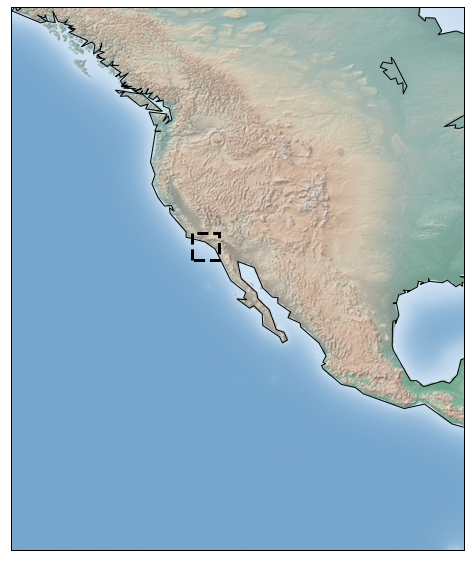

In [6]:
'''
# Example in June 2022 review does this bb, but I am not sure if I should make it this small: 
la_ports_bb = {
    'min_lon': -118.31,
    'max_lon': -118.09,
    'min_lat': 33.61,
    'max_lat': 33.87
}'''
la_ports_bb = {
    'min_lon': -120,
    'max_lon': -117,
    'min_lat': 32,
    'max_lat': 35
}
la_ports_basemap_range = {
    'llcrnrlon': -140,
    'llcrnrlat': 0,
    'urcrnrlon': -90,
    'urcrnrlat': 60
}

la_ports_start_time = datetime(2021,10,1)
la_ports_end_time = datetime(2021,12,31)

la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plot_box(la_ports_bbox, la_ports_basemap_range)

In [7]:
la_ports_tropomi_so2 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 3.307336417001352 seconds


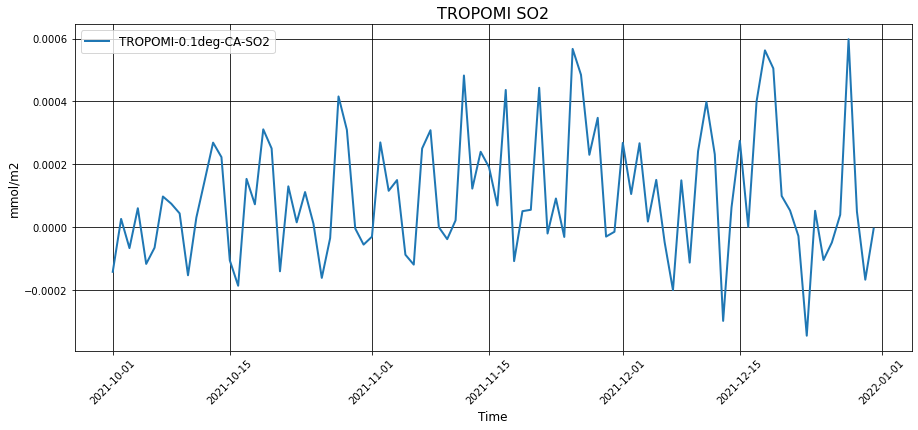

In [8]:
comparison_plot([la_ports_tropomi_so2], 'Time', units['SO2'], var='TROPOMI SO2')

## Probably not the best examples for the notebook, but keeping it in here in case someone else thinks otherwise

In [9]:
tropomi_o3 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-O3', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.45035762499901466 seconds


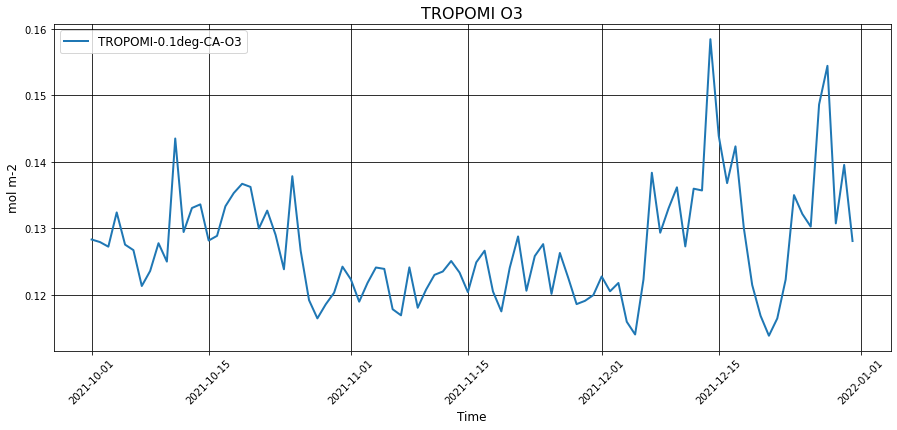

In [10]:
comparison_plot([tropomi_o3], 'Time', units['O3'], var='TROPOMI O3')

In [11]:
tropomi_no2 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-NO2', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.3848096660003648 seconds


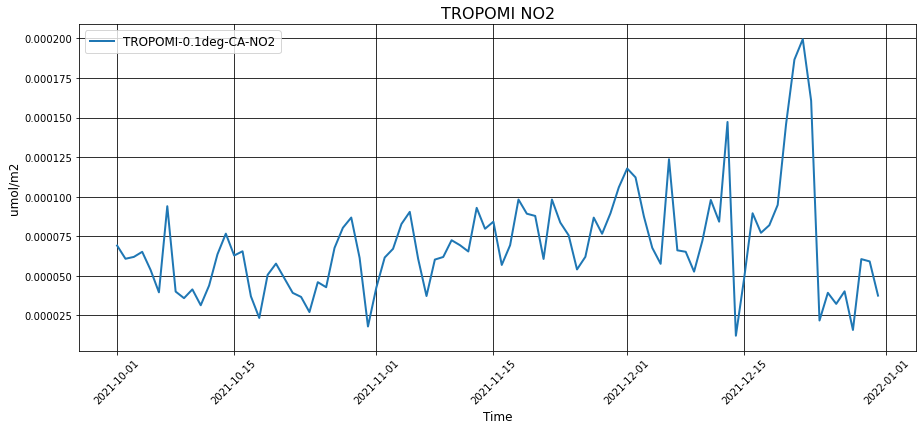

In [12]:
comparison_plot([tropomi_no2], 'Time', units['NO2'], var='TROPOMI NO2')

In [13]:
tropomi_co = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-CO', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CO&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.3782949579981505 seconds


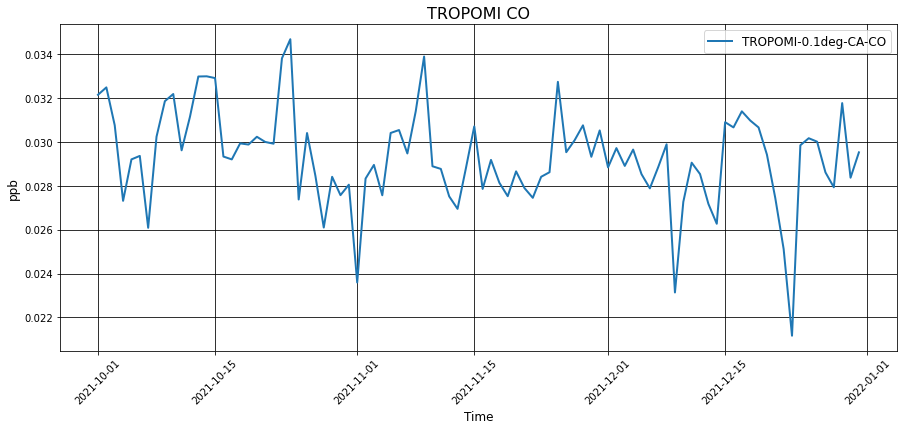

In [14]:
comparison_plot([tropomi_co], 'Time', units['CO'], var='TROPOMI CO')

In [15]:
tropomi_ch4 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-CH4', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CH4&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.3752953750008601 seconds


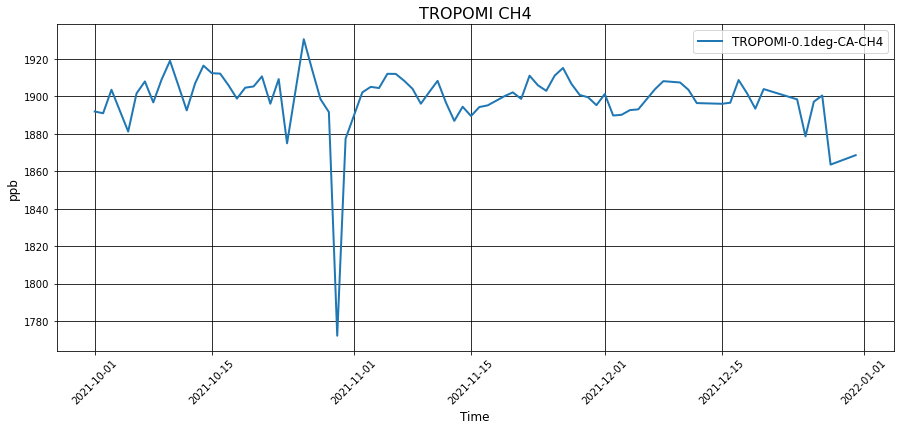

In [16]:
comparison_plot([tropomi_ch4], 'Time', units['CH4'], var='TROPOMI CH4')

# 2020 California Wildfires 
The 2020 California wildfire season was one of the worst on record with about 4.3 million acres burned

#### My notes
Started August, but ended November or December?  
Note that only O3 and SO2 data is available for this time period  

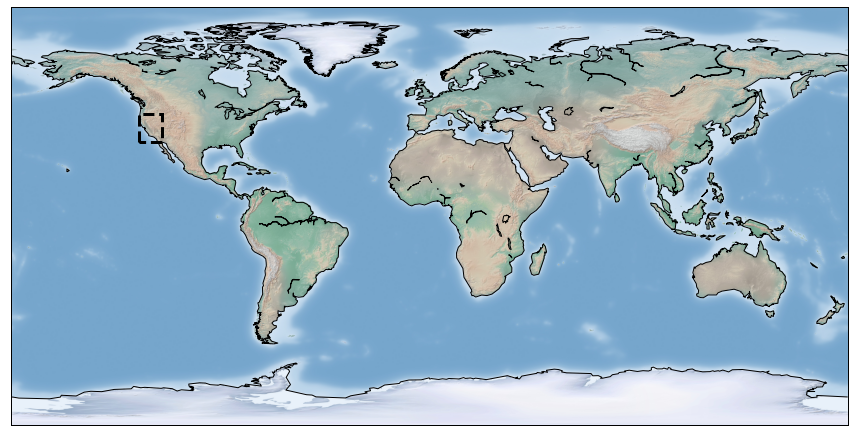

In [17]:
wildfires_bb = {
    'min_lon': -125,
    'max_lon': -115,
    'min_lat': 32,
    'max_lat': 44
}

wildfires_start_time = datetime(2020,8,1)
wildfires_end_time = datetime(2020,11,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plot_box(wildfires_bbox)

In [18]:
tropomi_so2 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 1.3188521249976475 seconds


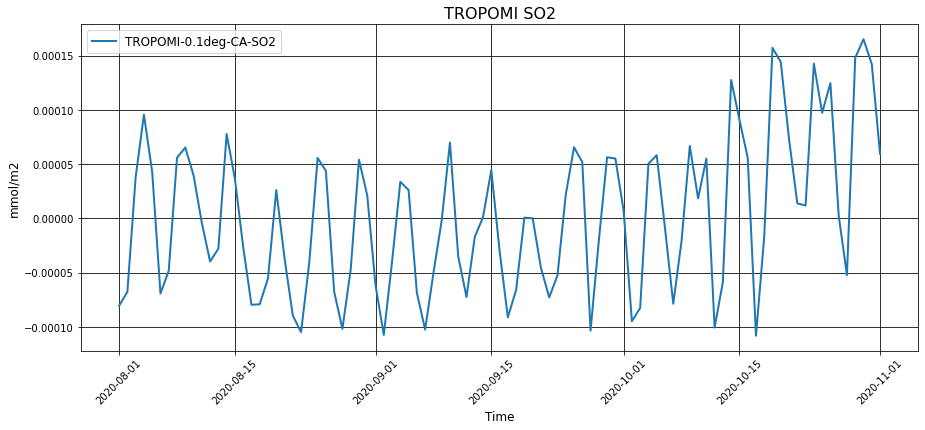

In [19]:
comparison_plot([tropomi_so2], 'Time', units['SO2'], var='TROPOMI SO2')

In [20]:
tropomi_o3 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-O3', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 1.305651124999713 seconds


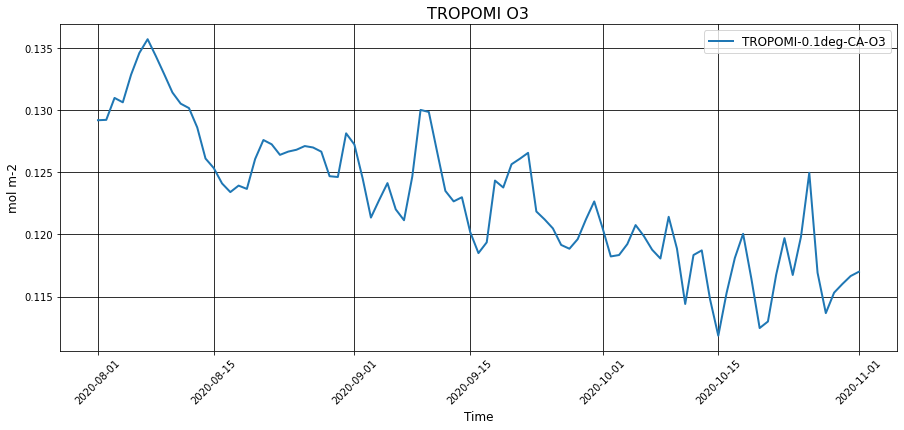

In [21]:
comparison_plot([tropomi_o3], 'Time', units['O3'], var='TROPOMI O3')

https://aq-sdap.stcenter.net/nexus//timeSeriesSpark?ds=OMI-0.25deg-monthly-Global-NO2&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 4.1973576249984035 seconds


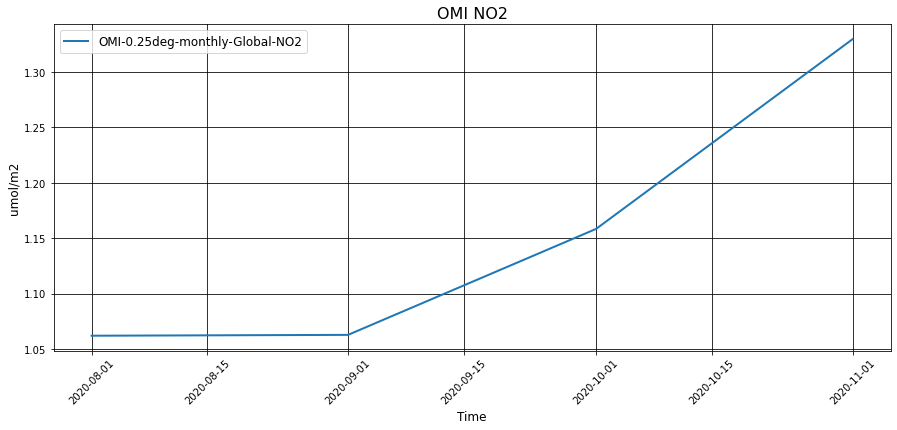

In [22]:
#Note that data might be too spread
wildfires_omi_no2 = spatial_mean(gmu_base_url, 'OMI-0.25deg-monthly-Global-NO2', wildfires_bb, wildfires_start_time, wildfires_end_time)
comparison_plot([wildfires_omi_no2], 'Time', units['NO2'], var='OMI NO2')

In [23]:
wildfires_temp_var_tropomi_so2 = temporal_variance(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z

Waiting for response from SDAP...
Time series took 6.805624333999731 seconds


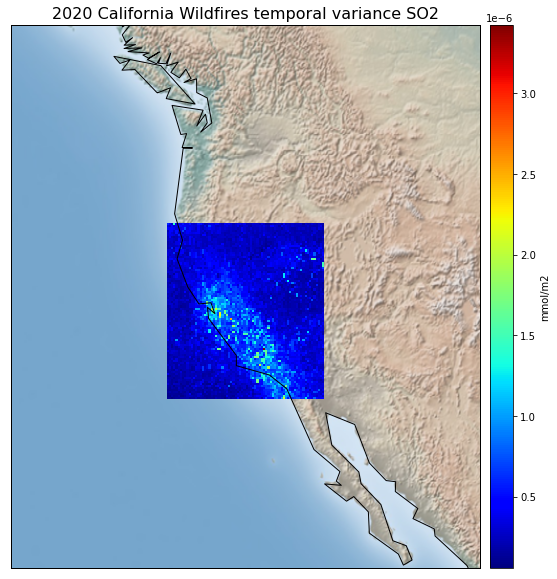

In [24]:
plot_map(wildfires_temp_var_tropomi_so2, "2020 California Wildfires temporal variance SO2", units['SO2'])

In [25]:
wildfires_temp_var_tropomi_o3 = temporal_variance(aq_base_url, 'TROPOMI-0.1deg-CA-O3', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z

Waiting for response from SDAP...
Time series took 6.9068210830009775 seconds


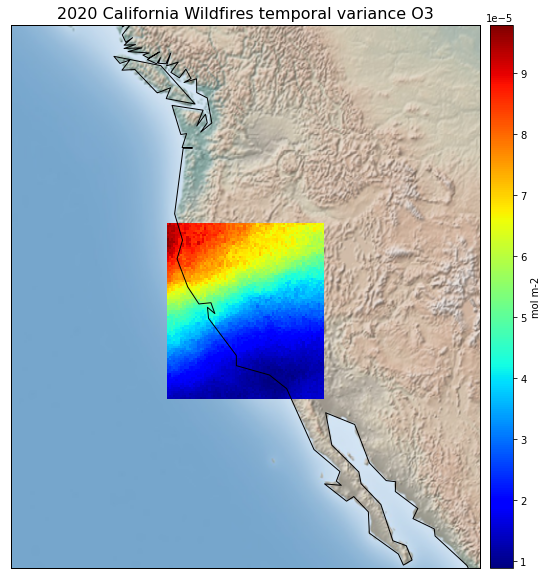

In [26]:
plot_map(wildfires_temp_var_tropomi_o3, "2020 California Wildfires temporal variance O3", units['O3'])

# Fireworks during 4th of July 2022 in Los Angeles County
Despite fireworks being outlawed for personal use in Los Angeles County, there is a significant amount of illegal fireworks displays in the area around 4th of July that cause very smoggy conditions.  
Below we model our in situ Particulate matter 2.5 and Black Carbon data from around 4th of July 

### Get PM 2.5 and BC from B301 GRIMM Aethalometer (2021-06-28 to 2021-07-11)

In [27]:
start_time_fireworks      = '2021-06-28T00:00:00Z'
end_time_fireworks        = '2021-07-11T00:00:00Z'
min_lon_fireworks         = -120
max_lon_fireworks         = -115
min_lat_fireworks         = 30
max_lat_fireworks         = 40
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2021_fireworks  = get_in_situ_data(start_time_fireworks, end_time_fireworks,
                        min_lon_fireworks, max_lon_fireworks, min_lat_fireworks, max_lat_fireworks, provider_fireworks)
pm25_bc_2021_fireworks 

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms?startIndex=0&itemsPerPage=500&startTime=2021-06-28T00:00:00Z&endTime=2021-07-11T00:00:00Z&bbox=-120,30,-115,40&provider=B301-GRIMM-Aethalometer


,provider,time,latitude,longitude,pm2_5,bc,project,job_id
0,B301-GRIMM-Aethalometer,2021-06-28T00:00:00Z,34.2013,-118.1714,11.362640,0.757350,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
1,B301-GRIMM-Aethalometer,2021-06-28T01:00:00Z,34.2013,-118.1714,14.981810,0.713367,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
2,B301-GRIMM-Aethalometer,2021-06-28T02:00:00Z,34.2013,-118.1714,15.210835,0.805733,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
3,B301-GRIMM-Aethalometer,2021-06-28T03:00:00Z,34.2013,-118.1714,15.090975,0.844900,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
4,B301-GRIMM-Aethalometer,2021-06-28T04:00:00Z,34.2013,-118.1714,13.934720,0.793133,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
...,...,...,...,...,...,...,...,...
305,B301-GRIMM-Aethalometer,2021-07-10T20:00:00Z,34.2013,-118.1714,10.701110,0.731567,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
306,B301-GRIMM-Aethalometer,2021-07-10T21:00:00Z,34.2013,-118.1714,10.899160,0.801967,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
307,B301-GRIMM-Aethalometer,2021-07-10T22:00:00Z,34.2013,-118.1714,11.520140,0.916000,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
308,B301-GRIMM-Aethalometer,2021-07-10T23:00:00Z,34.2013,-118.1714,11.639300,0.823983,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b


### Get PM 2.5 and BC from B301 GRIMM Aethalometer (2022-06-28 to 2022-07-11)

In [28]:
start_time_fireworks      = '2022-06-28T00:00:00Z'
end_time_fireworks        = '2022-07-11T00:00:00Z'
min_lon_fireworks         = -120
max_lon_fireworks         = -115
min_lat_fireworks         = 30
max_lat_fireworks         = 40
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2022_fireworks  = get_in_situ_data(start_time_fireworks, end_time_fireworks,
                        min_lon_fireworks, max_lon_fireworks, min_lat_fireworks, max_lat_fireworks, provider_fireworks)
pm25_bc_2022_fireworks 

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms?startIndex=0&itemsPerPage=500&startTime=2022-06-28T00:00:00Z&endTime=2022-07-11T00:00:00Z&bbox=-120,30,-115,40&provider=B301-GRIMM-Aethalometer


,provider,time,latitude,longitude,pm2_5,bc,project,job_id
0,B301-GRIMM-Aethalometer,2022-06-28T00:00:00Z,34.2013,-118.1714,11.296105,0.589517,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
1,B301-GRIMM-Aethalometer,2022-06-28T01:00:00Z,34.2013,-118.1714,10.009993,0.516750,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
2,B301-GRIMM-Aethalometer,2022-06-28T02:00:00Z,34.2013,-118.1714,8.843898,0.445650,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
3,B301-GRIMM-Aethalometer,2022-06-28T03:00:00Z,34.2013,-118.1714,8.405561,0.423650,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
4,B301-GRIMM-Aethalometer,2022-06-28T04:00:00Z,34.2013,-118.1714,7.942223,0.444567,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
...,...,...,...,...,...,...,...,...
199,B301-GRIMM-Aethalometer,2022-07-06T07:00:00Z,34.2013,-118.1714,14.065560,0.412217,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
200,B301-GRIMM-Aethalometer,2022-07-06T08:00:00Z,34.2013,-118.1714,13.312225,0.518117,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
201,B301-GRIMM-Aethalometer,2022-07-06T09:00:00Z,34.2013,-118.1714,14.277790,1.410283,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b
202,B301-GRIMM-Aethalometer,2022-07-06T10:00:00Z,34.2013,-118.1714,12.637220,0.891233,AQACF,b69cf0d6-e502-4943-89d5-cc1ddbc8362b


## Compare 2021 and 2022 emissions 
Unlike last year, PM2.5 levels showed only a minor elevation during the night of July 4th. However, a large peak (up to 100 µg/m3) was observed during the morning of July5th, comparable to the levels measured last year, most likely due to the transport of smoke from South/Central LA.

As expected, BC levels did not show an appreciable increase during the fireworks event. Fireworks do not emit very large amounts of BC relative to other species. Organic and inorganic aerosols (particularly metals) dominate emissions from fireworks. A PM2.5 sample was collected, using AMOD, for chemical analysis which includes XRF for detection of metals.

In [29]:
time_2021_fireworks = np.array(pm25_bc_2021_fireworks['time'])
pm25_2021_fireworks = np.array(pm25_bc_2021_fireworks['pm2_5'])
bc_2021_fireworks   = np.array(pm25_bc_2021_fireworks['bc'])

time_2022_fireworks = np.array(pm25_bc_2022_fireworks['time'])
pm25_2022_fireworks = np.array(pm25_bc_2022_fireworks['pm2_5'])
bc_2022_fireworks   = np.array(pm25_bc_2022_fireworks['bc'])

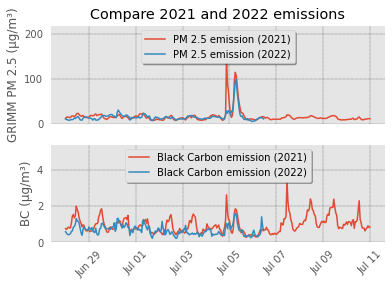

In [32]:
y_datas = [ pm25_2021_fireworks, pm25_2022_fireworks, bc_2021_fireworks, bc_2022_fireworks ]
x_datas = [ time_2021_fireworks, time_2022_fireworks, time_2021_fireworks, time_2022_fireworks ]
series_labels = [ 'PM 2.5 emission (2021)', 'PM 2.5 emission (2022)', 
                  'Black Carbon emission (2021)', 'Black Carbon emission (2022)' ]
y_labels = [ 'GRIMM PM 2.5 (µg/m³)', 'BC (µg/m³)' ]

stacked_overlay_plot(x_datas=x_datas, y_datas=y_datas, series_labels=series_labels,
                       y_labels=y_labels, title='Compare 2021 and 2022 emissions', top_paddings=[80, 2])